# Computer Vision Assignment: Face Recognizer

Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


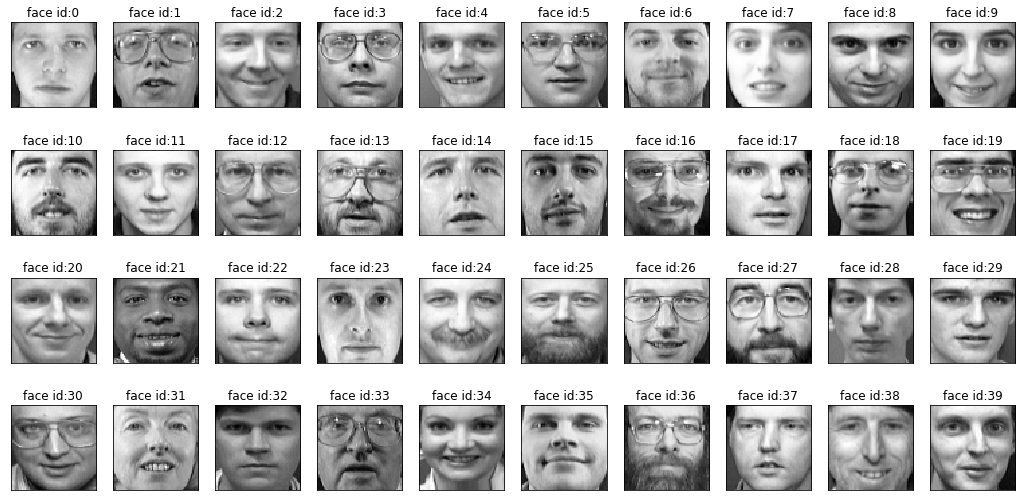

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(len(X_train), len(X_test))

360 40


In [3]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.image as img
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.io import imread, imsave
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from skimage.util import random_noise

C:\Users\dbdms\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

In [5]:
final_train_data = []
final_target_train = []

for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(X_train[i]))
    final_train_data.append(np.flipud(X_train[i]))
    for j in range(4):
        final_target_train.append(y_train[i])

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 774.60it/s]


In [6]:
len(final_target_train), len(final_train_data)

(1440, 1440)

In [7]:
X_train = np.array(final_train_data)
y_train = np.array(final_target_train)

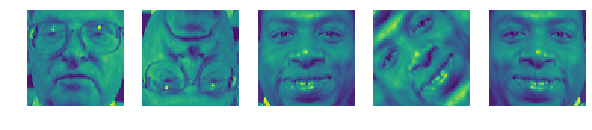

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(10,10))
for i in range(5):
    ax[i].imshow(X_train[i+30])
    ax[i].axis('off')

In [9]:
from torch.utils.data import TensorDataset

In [10]:
X_train = X_train[:, np.newaxis]
X_train = np.tile(X_train, (1, 3, 1, 1))
X_test = X_test[:, np.newaxis]
X_test = np.tile(X_test, (1, 3, 1, 1))

In [11]:
X_train=torch.from_numpy(X_train)
y_train=torch.from_numpy(y_train)

In [12]:
train_data = TensorDataset(X_train,y_train)

In [13]:
train_loader=DataLoader(train_data,batch_size=40, shuffle=True)

In [14]:
X_test=torch.from_numpy(X_test)
y_test=torch.from_numpy(y_test)

In [15]:
test_data = TensorDataset(X_test,y_test)

In [16]:
test_loader = DataLoader(test_data,batch_size=4,shuffle=False)

https://www.analyticsvidhya.com/blog/2020/07/how-to-train-an-image-classification-model-in-pytorch-and-tensorflow/

https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-10_5_2_Aadvance-CNN(VGG_cifar10).ipynb

In [17]:
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          # Defining another 2D convolution layer
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )
    
      self.linear_layers = Sequential(
            torch.nn.Linear(1024,512,bias=True),
            ReLU(inplace=True),
            torch.nn.Linear(512,256,bias=True),
            ReLU(inplace=True),
            torch.nn.Linear(256,40,bias=True),         
        )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [18]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = nn.CrossEntropyLoss()

In [19]:
print(len(train_loader))
epochs = 30

for epoch in range(epochs):  
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs = inputs
        labels = labels

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 15 == 14:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        

print('Finished Training')

36
[1,    15] loss: 5.436
[1,    30] loss: 4.869
[2,    15] loss: 3.697
[2,    30] loss: 2.994
[3,    15] loss: 1.927
[3,    30] loss: 1.633
[4,    15] loss: 0.925
[4,    30] loss: 0.836
[5,    15] loss: 0.493
[5,    30] loss: 0.402
[6,    15] loss: 0.211
[6,    30] loss: 0.222
[7,    15] loss: 0.177
[7,    30] loss: 0.125
[8,    15] loss: 0.133
[8,    30] loss: 0.121
[9,    15] loss: 0.121
[9,    30] loss: 0.116
[10,    15] loss: 0.056
[10,    30] loss: 0.029
[11,    15] loss: 0.024
[11,    30] loss: 0.015
[12,    15] loss: 0.010
[12,    30] loss: 0.009
[13,    15] loss: 0.008
[13,    30] loss: 0.006
[14,    15] loss: 0.006
[14,    30] loss: 0.006
[15,    15] loss: 0.004
[15,    30] loss: 0.006
[16,    15] loss: 0.005
[16,    30] loss: 0.004
[17,    15] loss: 0.003
[17,    30] loss: 0.005
[18,    15] loss: 0.004
[18,    30] loss: 0.003
[19,    15] loss: 0.003
[19,    30] loss: 0.003
[20,    15] loss: 0.003
[20,    30] loss: 0.002
[21,    15] loss: 0.003
[21,    30] loss: 0.003
[22,   

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))